In [255]:
import math

import ConnectionNetworkX as cnx
import numpy as np
import networkx as nx
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm


# Solving the Beckmann problem on a grid graph, i.e., pixel space.

Initialize the grid graph

[0.90179751 0.90179751 0.56808475 0.56808475 0.32069218 0.32069218
 0.26000223 0.26000223 0.01508784 0.01508784]
MOST LIKELY INCONSISTENT: |lambda_min| >= 1e-8. 


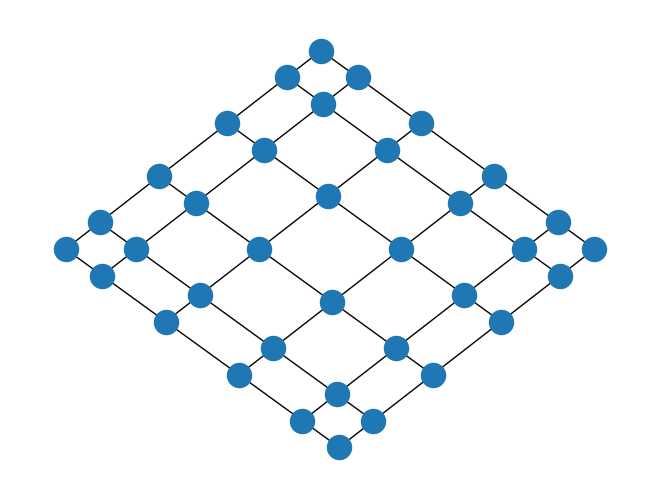

In [256]:

GRID_WIDTH = 6
GRID_HEIGHT = 6
INTRINSIC_DIM = 2

ADD_ROTATIONAL_PERTURBATION = True
THETA = math.pi / 2

gridGraph = cnx.cnxFromPixelGrid(GRID_WIDTH, GRID_HEIGHT, INTRINSIC_DIM)

if ADD_ROTATIONAL_PERTURBATION:

    r = np.array([[math.cos(THETA), -math.sin(THETA)], [math.sin(THETA), math.cos(THETA)]])
    gridGraph.updateEdgeSignature((0,1), r)

gridGraph.printConnectionLaplacianEigenvalues()
nx.draw_spectral(gridGraph)

gridGraphIncidenceMatrix = gridGraph.connectionIncidenceMatrix


Implement some utility/optimization methods for solving the regularized L1 beckmann problem

In [257]:
import torch

'''
phi,c: |V|d x 1
B: |E|d x |V|d      Connection incidence matrixI
c: |V|d x 1         c = alpha-beta; i.e. difference of densities
'''
def loss_fn(phi, B, w, c):
    loss0 = -torch.sum(phi*c)

    loss1 = torch.matmul(B, phi).reshape((w.shape[0],-1))
    loss1 = torch.linalg.norm(loss1, dim=1)
    loss1 = loss1 - w
    loss1 = torch.nn.ReLU()(loss1)
    loss1 = torch.sum(loss1**2)

    return loss0, loss1

def active_edges(phi, B, w, c):
    loss1 = torch.matmul(B, phi).reshape((w.shape[0],-1))
    loss1 = torch.linalg.norm(loss1, dim=1)
    loss1 = loss1 - w
    return loss1

def optimize(B, w, c, alpha, learning_rate, n_epochs, phi0 = None, print_freq=10):
    if phi0 is None:
        phi = torch.randn(B.shape[1], 1, requires_grad=True)
    else:
        phi = torch.tensor(phi0, requires_grad=True)
    optimizer = torch.optim.Adam([phi], lr=learning_rate)
    for epoch in range(n_epochs):
        # Compute loss
        loss0, loss1 = loss_fn(phi, B, w, c)
        loss = loss0 + (0.5/alpha)*loss1

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % print_freq == 0:
            print(f"epoch: {epoch}, loss: {loss:>7f}, loss0: {loss0:>7f}, loss1: {loss1:>7f}")
    return phi

Generate the constraint matrices and densities to be transported. Example seen here is dirac densities at corners of the grid.

In [258]:
import torch

FROM_NODE_INDEX = 0
TO_NODE_INDEX = 35

mu = np.zeros((gridGraph.nNodes * INTRINSIC_DIM, 1)).flatten()[:,None]
nu = np.zeros((gridGraph.nNodes * INTRINSIC_DIM, 1)).flatten()[:,None]

mu[ (FROM_NODE_INDEX * INTRINSIC_DIM) : ((FROM_NODE_INDEX + 1) * INTRINSIC_DIM)] = 1
nu[ (TO_NODE_INDEX * INTRINSIC_DIM) : ((TO_NODE_INDEX + 1) * INTRINSIC_DIM)] = 1

c = mu - nu
c.reshape((gridGraph.nNodes, INTRINSIC_DIM))

B = torch.tensor(gridGraphIncidenceMatrix.toarray())
w = torch.tensor(np.ones(B.T.shape[0]//INTRINSIC_DIM).astype('float32'))
c = torch.tensor(c)

# L2 least squares
#leastSquarePrimal, _, _, _ = np.linalg.lstsq(B.detach().numpy(), c.detach().numpy())
initialPhi = -np.matmul(np.linalg.pinv(np.matmul(B, B.T)), c)

#c_sol1 = active_edges(c_sol, B, w, c)
#c_sol1 = c_sol.detach().numpy()
#print(c_sol1)


In [259]:

learning_rate = 0.1
alpha = 1
n_epochs = 10000

print(B.T.shape)
print(c.shape)
print(w.shape)
print(initialPhi.shape)

gridPhi = optimize(B.T, w, c, alpha, learning_rate, n_epochs, phi0=initialPhi)

torch.Size([120, 72])
torch.Size([72, 1])
torch.Size([60])
torch.Size([72, 1])
epoch: 0, loss: 6.474163, loss0: 6.388377, loss1: 0.171573
epoch: 10, loss: 2.448172, loss0: 2.421523, loss1: 0.053297
epoch: 20, loss: -1.056662, loss0: -1.279393, loss1: 0.445462
epoch: 30, loss: -4.353824, loss0: -4.615496, loss1: 0.523343
epoch: 40, loss: -7.138597, loss0: -7.774337, loss1: 1.271481
epoch: 50, loss: -9.429310, loss0: -10.418725, loss1: 1.978830
epoch: 60, loss: -11.297432, loss0: -12.752661, loss1: 2.910459
epoch: 70, loss: -12.686843, loss0: -14.735806, loss1: 4.097925
epoch: 80, loss: -13.726164, loss0: -16.137369, loss1: 4.822411
epoch: 90, loss: -14.589159, loss0: -16.890952, loss1: 4.603585
epoch: 100, loss: -15.293661, loss0: -17.419138, loss1: 4.250954
epoch: 110, loss: -15.858554, loss0: -17.930308, loss1: 4.143509
epoch: 120, loss: -16.298330, loss0: -18.412122, loss1: 4.227585
epoch: 130, loss: -16.631178, loss0: -18.839017, loss1: 4.415678
epoch: 140, loss: -16.877791, loss0: 

C:\Users\Sawyer\AppData\Local\Temp\ipykernel_17680\1355371535.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(phi0, requires_grad=True)


epoch: 930, loss: -17.423165, loss0: -20.704784, loss1: 6.563238
epoch: 940, loss: -17.384902, loss0: -20.703813, loss1: 6.637822
epoch: 950, loss: -17.415971, loss0: -20.702204, loss1: 6.572465
epoch: 960, loss: -17.419569, loss0: -20.704908, loss1: 6.570680
epoch: 970, loss: -17.421271, loss0: -20.701084, loss1: 6.559625
epoch: 980, loss: -17.422442, loss0: -20.687448, loss1: 6.530011
epoch: 990, loss: -17.423060, loss0: -20.684281, loss1: 6.522442
epoch: 1000, loss: -17.423329, loss0: -20.703770, loss1: 6.560881
epoch: 1010, loss: -17.423419, loss0: -20.706368, loss1: 6.565898
epoch: 1020, loss: -17.423449, loss0: -20.702858, loss1: 6.558818
epoch: 1030, loss: -17.423461, loss0: -20.705206, loss1: 6.563490
epoch: 1040, loss: -17.423462, loss0: -20.705314, loss1: 6.563704
epoch: 1050, loss: -17.423463, loss0: -20.704421, loss1: 6.561916
epoch: 1060, loss: -17.423463, loss0: -20.704816, loss1: 6.562705
epoch: 1070, loss: -17.423463, loss0: -20.704932, loss1: 6.562938
epoch: 1080, loss

# Visualizing the Soln. to the Connection Beckmann Problem on a Grid

In [260]:
gridPhi.detach().numpy()

array([[ 1.23979775],
       [ 3.27316098],
       [-2.62134808],
       [ 0.52735002],
       [-3.21387608],
       [-0.26741433],
       [-3.70829634],
       [-1.07205444],
       [-4.26636854],
       [-1.86843623],
       [-4.81997044],
       [-2.60299876],
       [-0.46741613],
       [ 1.5659471 ],
       [-1.68382281],
       [ 0.34954042],
       [-2.70762835],
       [-0.67426512],
       [-3.63342329],
       [-1.60006006],
       [-4.48883494],
       [-2.45547171],
       [-5.27361609],
       [-3.24025287],
       [-1.6650008 ],
       [ 0.36836243],
       [-2.5838834 ],
       [-0.55052017],
       [-3.51235581],
       [-1.47899258],
       [-4.41134523],
       [-2.377982  ],
       [-5.26610574],
       [-3.23274251],
       [-6.05871947],
       [-4.02535624],
       [-2.65114467],
       [-0.61778145],
       [-3.4738814 ],
       [-1.44051818],
       [-4.34708855],
       [-2.31372532],
       [-5.23291638],
       [-3.19955316],
       [-6.1061509 ],
       [-4

100%|██████████| 36/36 [00:00<00:00, 1049.40it/s]


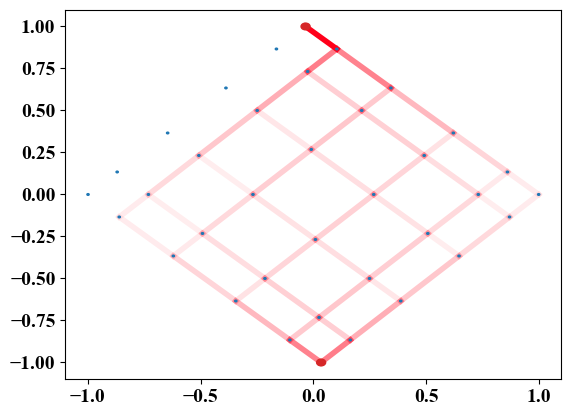

In [261]:

regularizedActiveEdges = active_edges(gridPhi, B.T, w, c).detach().numpy()

spectralEmbedding = nx.spectral_layout(gridGraph)

TOLERANCE = 0
MAX = np.max(abs(regularizedActiveEdges))

fig, ax = plt.subplots()
ax.set_xlim((-1.1, 1.1))
ax.set_ylim((-1.1, 1.1))

for node in tqdm(list(range(gridGraph.nNodes))):
    center = spectralEmbedding[node][0], spectralEmbedding[node][1]
    if node in [FROM_NODE_INDEX, TO_NODE_INDEX]:
        col="tab:red"
        zNode=4
        r=2e-2
         #ax.text(center[0], center[1], str(node+1))
    else:
        col="tab:blue"
        zNode=4
        r=5e-3
    nodeLabel = matplotlib.patches.Circle(center, radius=r, color=col, zorder=zNode)
    ax.add_patch(nodeLabel)

for edgeIndex, edge in zip(range(gridGraph.nEdges), list(gridGraph.edges())):

    if regularizedActiveEdges[edgeIndex] > TOLERANCE:
        col=(1, 0, .1, abs(regularizedActiveEdges[edgeIndex])/MAX)
        z = 3
        lw = 4
    else:
        #col="tab:blue"
        lw=0.5
        col=(1,1,1,0)
        z = 3

    fromNode = edge[0]
    toNode = edge[1]
    centerFromNode = spectralEmbedding[fromNode][0], spectralEmbedding[fromNode][1]
    centerToNode = spectralEmbedding[toNode][0], spectralEmbedding[toNode][1]

    ax.plot((centerFromNode[0], centerToNode[0]), (centerFromNode[1], centerToNode[1]), color=col, lw=lw)
    # edgeLabel = Line3D((centerFromNode[0], centerToNode[0]), (centerFromNode[1], centerToNode[1]), (centerFromNode[2], centerToNode[2]), color=col, lw=3)
    # edgeLabel.zorder = z
    # ax.add_line(edgeLabel)

plt.show()

# xData, yData = spectralEmbedding.values


In [262]:
regularizedActiveEdges

array([-0.03436973,  1.41436503, -0.00866766, -0.04576215, -0.05559696,
       -0.35052766, -0.0275451 , -0.46671217, -0.08018633, -0.3722246 ,
       -0.21776783,  0.72025882,  0.69364048,  0.44787968,  0.27287789,
        0.30927176,  0.13805649,  0.20973475,  0.10014777,  0.10984816,
        0.09922691,  0.11030384,  0.29949624,  0.39461805,  0.31305828,
        0.25864725,  0.27136303,  0.18049036,  0.2088139 ,  0.16187707,
        0.12092509,  0.18800327,  0.23053854,  0.16352544,  0.23061001,
        0.23490139,  0.18794904,  0.25274974,  0.16189626,  0.2349401 ,
        0.18051292,  0.16346036,  0.25858946,  0.39469364,  0.12086447,
        0.11023736,  0.20884861,  0.09927672,  0.27136639,  0.10013183,
        0.31301664,  0.13803193,  0.29956454,  0.27293733,  0.69356273,
        0.10990382,  0.20970373,  0.30926649,  0.44792204,  0.72018994])